In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base=automap_base()

# reflect the tables

Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Measurement=Base.classes.measurement

Stations=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session=Session(engine)

## AdvancedTempAnalysis2

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
calc_temps('2012-02-28', '2012-03-05')



[(16.7, 20.873214285714287, 23.3)]

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

SetAYear=calc_temps('2017-08-01', '2017-08-07')
SetAYear

[(22.2, 26.25, 28.3)]

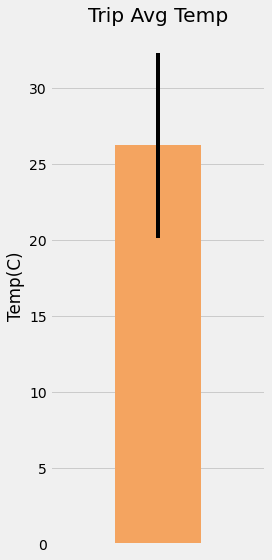

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,8))
label=['temp']
x=np.arange(len(label))
y=SetAYear[0][1]
yerr=SetAYear[0][2]-SetAYear[0][0]
plt.bar(x,y,yerr=yerr,width=0.8,color='sandybrown')
plt.title('Trip Avg Temp')
plt.ylabel('Temp(C)')
plt.xlim(-1,1)
plt.xticks([])
plt.tight_layout()
plt.savefig('OutputData/temperature.png')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=(func.sum(Measurement.prcp),Stations.station,Stations.name,Stations.latitude,Stations.longitude,Stations.elevation)
RrainfallPerWeatherStation=session.query(*sel).filter(Measurement.station==Stations.station).filter(Measurement.date >= '2017-08-01').\
    filter(Measurement.date <= '2017-08-07').group_by(Stations.station).order_by(func.sum(Measurement.prcp).desc()).all()

RrainfallPerWeatherStation

[(9.200000000000001, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 46.449),
 (5.6, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 2.133),
 (1.5, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84889, 10.027),
 (1.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.914),
 (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 5.943)]

### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(16.7, 20.64230769230769, 25.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
daterange=pd.date_range(start_date,end_date)


# Strip off the year and save a list of strings in the format %m-%d

Drange=daterange.strftime("%m-%d")
DrangeList=[data for data in Drange]



# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals=[]
for i in range(0,len(Drange)):
    normals.append(daily_normals(DrangeList[i]))

normals

[[(19.4, 24.186, 28.3)],
 [(20.0, 24.220754716981123, 28.9)],
 [(21.1, 24.77777777777778, 29.4)],
 [(20.6, 24.84038461538462, 28.9)],
 [(20.6, 24.529629629629632, 27.8)],
 [(19.4, 24.582142857142852, 28.3)],
 [(21.7, 25.08235294117647, 28.3)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin=[]
tavg=[]
tmax=[]

for i in range(len(normals)):
    tmin.append(normals[i][0][0])
    tavg.append(normals[i][0][1])
    tmax.append(normals[i][0][2])


df=pd.DataFrame({'tmin':tmin,'tmavg':tavg,'tmax':tmax},index=(DrangeList))
df

,tmin,tmavg,tmax
08-01,19.4,24.186000,28.3
08-02,20.0,24.220755,28.9
08-03,21.1,24.777778,29.4
08-04,20.6,24.840385,28.9
08-05,20.6,24.529630,27.8
08-06,19.4,24.582143,28.3
08-07,21.7,25.082353,28.3


/Users/huan-jhelin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<Figure size 576x432 with 0 Axes>

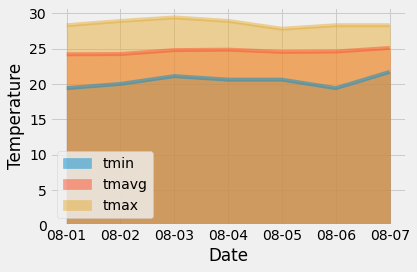

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=(8,6))
plot=df.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('OutputData/daily-normals.png')
plt.show()

## Close Session

In [17]:
session.close()